In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
from src.emfiles import get_data_from_df
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
import mrcfile

In [19]:
data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = data_dir + "job550_particles_roy10k.star"
#df = star.parse_star(star_file, keep_index = False)

imgs, pixel_size, angles, shifts, ctf_params = get_data_from_df(df, data_dir)

print(imgs.shape)
print(pixel_size.shape)
print(angles.shape)
print(shifts.shape)
print(ctf_params.shape)

(569, 308, 308)
(569,)
(569, 3)
(569, 2)
(569, 9)


In [20]:
imgs.shape

(569, 308, 308)

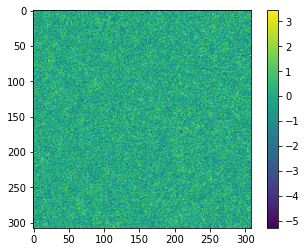

In [11]:
plt.imshow(imgs[10]); plt.colorbar()

In [12]:
l = range(10)

In [18]:
l[:10]

range(0, 10)